##### Analiza kohort lub inaczej analiza vintage: dla wybranych grub analizujemy w wybranych jednostkach czasu daną miarę, retencję, x-sella, szkodowość portfela itp.   
##### Definicja analizy kohortowej   
Cohort analysis is a kind of behavioral analytics that breaks the data in a data set into related groups before analysis. These groups, or cohorts, usually share common characteristics or experiences within a defined time-span.[1][2] Cohort analysis allows a company to "see patterns clearly across the life-cycle of a customer (or user), rather than slicing across all customers blindly without accounting for the natural cycle that a customer undergoes."[3] By seeing these patterns of time, a company can adapt and tailor its service to those specific cohorts. While cohort analysis is sometimes associated with a cohort study, they are different and should not be viewed as one and the same. Cohort analysis is specifically the analysis of cohorts in regards to big data and business analytics, while in cohort study, data is broken down into similar groups.  
https://en.wikipedia.org/wiki/Cohort_analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
from pathlib import Path
import os
import numpy as np

E:\Python\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Python\Anaconda\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
E:\Python\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


##### Pobranie danych  
https://archive.ics.uci.edu/ml/datasets/Online+Retail+II  
https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

Opis danych:  
__InvoiceNo:__ Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.  
__StockCode__: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.  
__Description__: Product (item) name. Nominal.  
__Quantity__: The quantities of each product (item) per transaction. Numeric.  
__InvoiceDate__: Invice date and time. Numeric. The day and time when a transaction was generated.  
__UnitPrice__: Unit price. Numeric. Product price per unit in sterling.  
__CustomerID__: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.  
__Country__: Country name. Nominal. The name of the country where a customer resides. 

In [3]:
# Wczytanie danych 
data_path = Path('./data/')
foto_path = Path('./foto/')


df = pd.read_excel(os.path.join(data_path, "online_retail_II.xlsx"),
                   dtype={'Customer ID': str,
                          'Invoice': str},
                   parse_dates=['InvoiceDate']) 
                   # infer_datetime_format=True) # niestety opcja nie działa, a szkoda bo przyśpiesza

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  object        
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 32.1+ MB


In [4]:
# wywalam nullowe rekordy z id klienta
df.dropna(subset=['Customer ID'], inplace=True)

In [5]:
# statystyki opisowe zadziałają jedynie na zmiennych numerycznych
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0,12.758815,101.220424,-9360.0,2.00,4.00,12.00,19152.00
Price,417534.0,3.887547,71.131797,0.0,1.25,1.95,3.75,25111.09


W powyższym zestawieniu widać, że występują ujemne wartości liczby zamówień (czyli dotyczą zapewne zwrotów). Wykasuję je, żeby nie zaburzały analizy

In [6]:
# statystyka ile zamówien było realizowanych przez każdego klienta
n_orders = df.groupby(['Customer ID'])['Invoice'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['Customer ID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% klientów zamówiło więcej niż raz.' )

71.09% klientów zamówiło więcej niż raz.


E:\Python\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


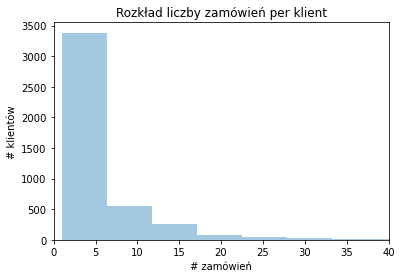

In [7]:
# szybki histogram 
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set_xlim(0,40) # ograniczenie dodane w drugiej kolejności
ax.set(title='Rozkład liczby zamówień per klient',
       xlabel='# zamówień', 
       ylabel='# klientów');

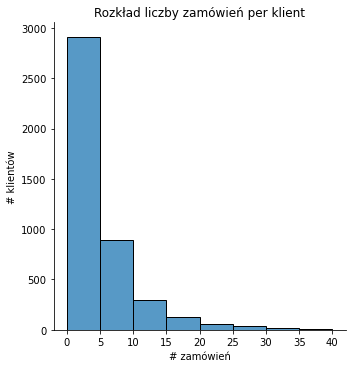

In [16]:
import seaborn as sns

# ax = sns.displot(data=n_orders, kde=False, stat="density", bins=range(0, 41,5))
ax = sns.displot(data=n_orders, kde=False, bins=range(0, 41,5))
ax.set(title='Rozkład liczby zamówień per klient', xlabel='# zamówień', ylabel='# klientów')
ax.despine();


In [17]:
# pozbywamy się niepotrzebnych kolumn oraz usówam duplikaty
df = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()

In [18]:
# tworzenie kohort oraz kolejnych miesięcy 
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('Customer ID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 



In [19]:
# agregacja po kohorcie oraz miesiącu zamówienia
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('Customer ID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [24]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2009-12,2009-12,1045,0
1,2009-12,2010-01,392,1
2,2009-12,2010-02,358,2
3,2009-12,2010-03,447,3
4,2009-12,2010-04,410,4
...,...,...,...,...
86,2010-10,2010-11,112,1
87,2010-10,2010-12,39,2
88,2010-11,2010-11,322,0
89,2010-11,2010-12,38,1


In [20]:
# pivotujemy tabelę z zamówienia
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [21]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

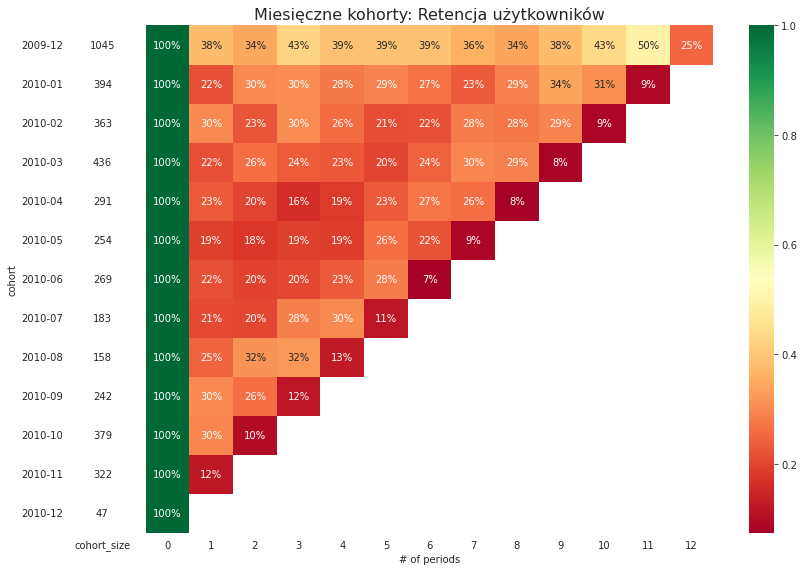

In [23]:
# na zakończenie macierz retencji oraz mapa ciepła
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Miesięczne kohorty: Retencja użytkowników', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    plt.savefig(os.path.join(foto_path, "cohort_chart.png"),format='png', dpi=300, facecolor="White")